# **Imports and Constants**

In [2]:
#imports
from __future__ import print_function
from pyspark import SparkContext
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from mpl_toolkits.mplot3d import Axes3D
from pyspark.sql.functions import col
from functools import reduce
from pyspark import SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.types import ArrayType, IntegerType
from pyspark.sql.functions import col, split, size, isnan, array_contains, array_min, when, count
from pyspark.sql.types import StructType, StructField, TimestampType, StringType, FloatType, BooleanType
import pyspark.sql.functions as f
import matplotlib.pyplot as plt
import pandas as pd 
import glob
import re
import pathlib
import json
import datetime
import numpy as np
import time
import os
import random
import statistics

#env variables
%env PYSPARK_DRIVER_PYTHON=python3.6 #same python version between worker and driver
%env PYSPARK_PYTHON=python3.6 #same python version between worker and driver
#incompatibility with Pyarrow
#need to install Pyarrow 0.14.1 or lower or Set the environment variable ARROW_PRE_0_15_IPC_FORMAT=1
%env ARROW_PRE_0_15_IPC_FORMAT=1 

#used versions: 
#spark='2.4.3' python='3.6' pyarrow='0.14.1' 

env: PYSPARK_DRIVER_PYTHON=python3.6
env: PYSPARK_PYTHON=python3.6
env: ARROW_PRE_0_15_IPC_FORMAT=1


In [3]:
#paths
DATASET_PATH='/Users/Soroush/Desktop/Thesis/Code/dataset/'

#from google.colab import drive
#drive.mount('/gdrive')

# **Load/Save Dataset**

In [4]:
#load and save .read_pickle() and .to_pickle() 

#save
#dataset.to_pickle(DATASET_PATH+"dataset.pkl")
#aggregated_dataset.to_pickle(DATASET_PATH+"aggregated_dataset.pkl")
#json_dataset.to_pickle(DATASET_PATH+"json_dataset.pkl")
#dataset.to_csv(DATASET_PATH+"dataset.csv")
#aggregated_dataset.to_csv(DATASET_PATH+"aggregated_dataset.csv")
#json_dataset.to_csv(DATASET_PATH+"json_dataset.csv")
#aggregated_dataset_rowBased.to_csv(DATASET_PATH+"aggregated_dataset_rowBased.csv")


#load
dataset=pd.read_pickle(DATASET_PATH+"dataset.pkl")
aggregated_dataset=pd.read_pickle(DATASET_PATH+"aggregated_dataset.pkl")
json_dataset=pd.read_pickle(DATASET_PATH+"json_dataset.pkl")

# **Malicious Samples**

In [5]:
# Generate malicious samples
def h1(x):
    MAX=0.8
    MIN=0.1
    alpha=random.uniform(MIN,MAX)
    temp=np.array(x)
    return (temp*alpha).tolist()

def h2(x):
    MIN_OFF=4 # hour
    DURATION=random.randint(MIN_OFF,24)
    START=random.randint(0,23-DURATION) if DURATION!=23 else 0
    END=START+DURATION
    temp=np.array(x)
    temp[START:END]=0
    return temp.tolist()
    
def h3(x):
    MAX=0.8
    MIN=0.1
    temp=[]
    for i in range(len(x)):
        temp.append(x[i]*random.uniform(MIN,MAX))
    return temp

def h4(x):
    MAX=0.8
    MIN=0.1
    mean=statistics.mean(x)
    temp=[]
    for i in range(len(x)):
        temp.append(mean*random.uniform(MIN,MAX))
    return temp

def h5(x):
    MAX=0.8
    MIN=0.1
    mean=statistics.mean(x)
    temp=[]
    for i in range(len(x)):
        temp.append(mean)
    return temp

def h6(x):
    temp=np.array(x)
    #temp=temp[::-1] 
    temp=np.flipud(temp) 
    return temp

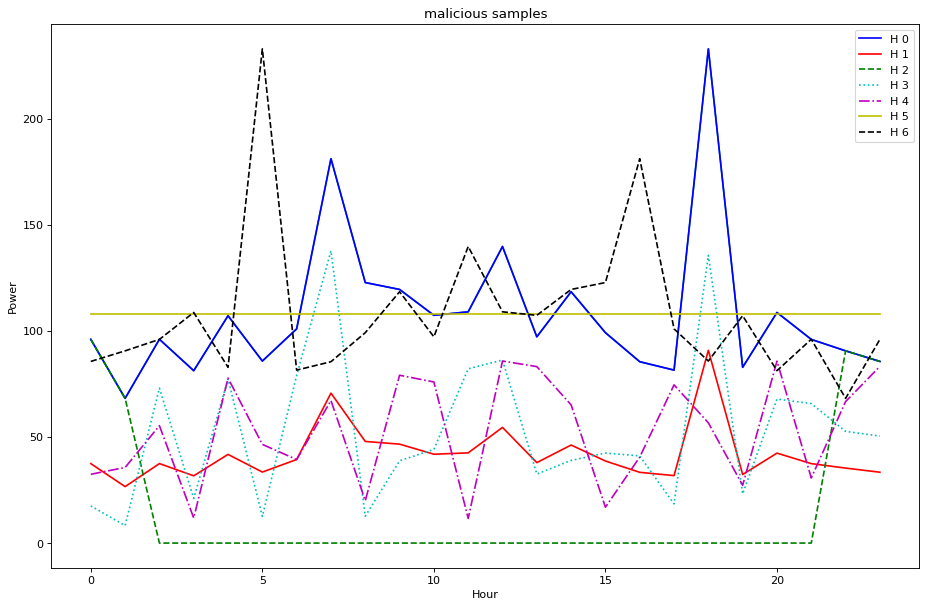

In [6]:
#plot
read_value=[96.00396728515625, 68.20671844482422, 96.05184936523438, 81.24053192138672, 107.14600372314453, 85.7899169921875, 100.9619140625, 181.16192626953125, 122.7833023071289, 119.53163146972656, 107.34815216064453, 108.99268341064453, 139.76922607421875, 97.21031951904297, 118.4515151977539, 99.15070343017578, 85.47505187988281, 81.51718139648438, 232.91493225097656, 82.83419799804688, 108.6827163696289, 95.99102020263672, 90.59868621826172, 85.60449981689453]
lists=[]
colors=['b','r-','g--','c:','m-.','y-','k--']
lists.append(read_value)
lists.append(h1(read_value))
lists.append(h2(read_value))
lists.append(h3(read_value))
lists.append(h4(read_value))
lists.append(h5(read_value))
lists.append(h6(read_value))
plt.figure(num=None, figsize=(14, 9), dpi=80, facecolor='w', edgecolor='k')
plt.xlabel("Hour")
plt.ylabel("Power")
plt.title("malicious samples")
plt.plot(read_value)
for i in range(len(lists)):
    plt.plot(lists[i],colors[i],label = 'H %s'%i)
plt.legend()
plt.show()

# **Prepare Spark Dataset**

In [7]:
#create SparkSession
spark = SparkSession.builder.appName("anomaly_detection").master("local[2]").getOrCreate()
#network problem? type it in commandline: sudo hostname -s 127.0.0.1

#define schema
schema = StructType([
    StructField("#", IntegerType()),
    StructField("date", TimestampType()),
    StructField("id", StringType()),
    StructField("power", StringType())])

#read data
sdf = spark.read.format('csv').options(header='true',inferSchema=True ,schema=schema).load(DATASET_PATH+"aggregated_dataset_rowBased.csv")

#rename columns
def rename_dataframe(sdf):
    names = ['#','date','id','power']
    for c,n in zip(sdf.columns,names):
        sdf=sdf.withColumnRenamed(c,n)
    return sdf
    
sdf=rename_dataframe(sdf)
#sdf.show()
    
#convert power to array
def string_power_to_array(sdf):
    temp=sdf.withColumn("power", f.regexp_replace(f.regexp_replace(f.col("power"), "\\[", ""),"\\]","")
                        .alias("power"))
    temp=temp.withColumn("power",split(col("power"), ",\s*")
                        .cast(ArrayType(FloatType())).alias("power"))
    return temp

sdf=string_power_to_array(sdf)
#sdf.show()

#add "v"alidation column
def add_validation_column(sdf):
    v=True
    temp=sdf.withColumn("V",f.when((size(sdf.power)==24) #array size
                                   & ~(f.array_contains(sdf.power, float('nan'))) #containing NaN
                                   & ~(f.array_max(sdf.power)<=0) #all 0
                                   , True).otherwise(False))
    return temp

sdf=add_validation_column(sdf)
#sdf.show()

#add "N"ormal consumption ("N"onmalicious) column
def add_Normal_column(sdf):
    N=True
    temp=sdf.withColumn("N", f.lit(N))
    return temp

sdf=add_Normal_column(sdf)
#sdf.show()

#filter data
def filter_dataset(sdf,from_date="2014-09-15",to_date="2014-09-26",ID="Apt99"):
    sdf=(sdf.filter(sdf.date > from_date) #filter date (from X)
    .filter(sdf.date <to_date ) #filter date (to Y)
    .filter(sdf.id == ID)) #filter IDs
    return sdf

sdf=filter_dataset(sdf)

#add malicious samples
#def add_malicious_samples(sdf):
#    return sdf

#sdf=add_malicious_samples(sdf)
#print(a.head())

def split_power(sdf):
    temp=sdf.select("#","date","id",
           sdf.power[0].alias("H0"), sdf.power[1].alias("H1"), sdf.power[2].alias("H2"),sdf.power[3].alias("H3"),
           sdf.power[4].alias("H4"), sdf.power[5].alias("H5"), sdf.power[6].alias("H6"),sdf.power[7].alias("H7"),
           sdf.power[8].alias("H8"), sdf.power[9].alias("H9"), sdf.power[10].alias("H10"),sdf.power[11].alias("H11"),
           sdf.power[12].alias("H12"), sdf.power[13].alias("H13"), sdf.power[14].alias("H14"),sdf.power[15].alias("H15"),
           sdf.power[16].alias("H16"), sdf.power[17].alias("H17"), sdf.power[18].alias("H18"),sdf.power[19].alias("H19"),
           sdf.power[20].alias("H20"), sdf.power[21].alias("H21"), sdf.power[22].alias("H22"),sdf.power[23].alias("H23"))
    return temp
    
#split_sdf=split_power(sdf)
#sdf.show()


sdf.show()
sdf.printSchema()
#split_sdf=add_validation_column(split_sdf)


+-----+-------------------+-----+--------------------+----+----+
|    #|               date|   id|               power|   V|   N|
+-----+-------------------+-----+--------------------+----+----+
|66713|2014-09-15 00:00:00|Apt99|[7.33332E-4, 7.33...|true|true|
|66714|2014-09-16 00:00:00|Apt99|[8.0E-4, 8.0E-4, ...|true|true|
|66715|2014-09-17 00:00:00|Apt99|[8.0E-4, 8.0E-4, ...|true|true|
|66716|2014-09-18 00:00:00|Apt99|[2.2008388, 3.001...|true|true|
|66717|2014-09-19 00:00:00|Apt99|[0.26381665, 12.5...|true|true|
|66718|2014-09-20 00:00:00|Apt99|[3.50608, 3.04037...|true|true|
|66719|2014-09-21 00:00:00|Apt99|[3.9555233, 3.294...|true|true|
|66720|2014-09-22 00:00:00|Apt99|[2.7298977, 14.12...|true|true|
|66721|2014-09-23 00:00:00|Apt99|[23.06501, 9.4872...|true|true|
|66722|2014-09-24 00:00:00|Apt99|[4.1672745, 5.679...|true|true|
|66723|2014-09-25 00:00:00|Apt99|[5.683941, 4.6325...|true|true|
+-----+-------------------+-----+--------------------+----+----+

root
 |-- #: integer (nu

In [7]:
#add_malicious_samples (with pandas)
temp=sdf.toPandas()
display(temp)
def random_attack_assigner(x):
    NUMBER_OF_MALICIOUS_GENERATOR=6
    rand = random.randint(1,NUMBER_OF_MALICIOUS_GENERATOR)
    if rand==1:
        return h1(x)
    elif rand==2:
        return h2(x)
    elif rand==3:
        return h3(x)
    elif rand==4:
        return h4(x)
    elif rand==5:
        return h5(x)
    elif rand==6:
        return h6(x)
temp['power'] = temp['power'].apply(random_attack_assigner)
temp['N']=False
display(temp)
#malicious_sdf = spark.createDataFrame(temp)
#malicious_sdf.head()

,#,date,id,power,V,N
0,66713,2014-09-15,Apt99,"[0.000733332009986043, 0.000733332009986043, 0...",True,True
1,66714,2014-09-16,Apt99,"[0.0007999999797903001, 0.0007999999797903001,...",True,True
2,66715,2014-09-17,Apt99,"[0.0007999999797903001, 0.0007999999797903001,...",True,True
3,66716,2014-09-18,Apt99,"[2.200838804244995, 3.0014467239379883, 1.8391...",True,True
4,66717,2014-09-19,Apt99,"[0.2638166546821594, 12.509289741516113, 5.367...",True,True
5,66718,2014-09-20,Apt99,"[3.506079912185669, 3.040369987487793, 6.74157...",True,True
6,66719,2014-09-21,Apt99,"[3.9555232524871826, 3.2945165634155273, 13.21...",True,True
7,66720,2014-09-22,Apt99,"[2.7298977375030518, 14.123311996459961, 19.02...",True,True
8,66721,2014-09-23,Apt99,"[23.06501007080078, 9.487234115600586, 10.1409...",True,True
9,66722,2014-09-24,Apt99,"[4.167274475097656, 5.679167747497559, 17.7766...",True,True


,#,date,id,power,V,N
0,66713,2014-09-15,Apt99,"[0.000737035799829755, 0.000737035799829755, 0...",True,False
1,66714,2014-09-16,Apt99,"[0.0003938362794185114, 0.0005050885181449161,...",True,False
2,66715,2014-09-17,Apt99,"[0.0007999999797903001, 0.0, 0.0, 0.0, 0.0, 0....",True,False
3,66716,2014-09-18,Apt99,"[2.200838804244995, 3.0014467239379883, 1.8391...",True,False
4,66717,2014-09-19,Apt99,"[0.1702003604157629, 8.070323024588133, 3.4625...",True,False
5,66718,2014-09-20,Apt99,"[2.0127039533860978, 1.7453580200225232, 3.870...",True,False
6,66719,2014-09-21,Apt99,"[8.103838920593262, 2.232825517654419, 3.86116...",True,False
7,66720,2014-09-22,Apt99,"[1.1654310337989573, 2.788992656707053, 3.7041...",True,False
8,66721,2014-09-23,Apt99,"[7.267358778694663, 2.9892522883753365, 3.1952...",True,False
9,66722,2014-09-24,Apt99,"[3.4386255741119385, 2.7355077266693115, 3.573...",True,False


In [97]:
def prepare_for_kmeans(sdf): 
    
    temp=sdf
    
    #define function for validation
    def add_validation_column(sdf):
        v=True
        temp=sdf.withColumn("V",f.when((size(sdf.power)==24) #array size
                                   & ~(f.array_contains(sdf.power, float('nan'))) #containing NaN
                                   & ~(f.array_max(sdf.power)<=0) #all 0
                                   , True).otherwise(False))
        return temp

    #call the split_power function
    temp=add_validation_column(temp)
    
    #define function for split power column
    def split_power(sdf):
        temp=sdf.select("#","V","date","id",
           sdf.power[0].alias("H0"), sdf.power[1].alias("H1"), sdf.power[2].alias("H2"),sdf.power[3].alias("H3"),
           sdf.power[4].alias("H4"), sdf.power[5].alias("H5"), sdf.power[6].alias("H6"),sdf.power[7].alias("H7"),
           sdf.power[8].alias("H8"), sdf.power[9].alias("H9"), sdf.power[10].alias("H10"),sdf.power[11].alias("H11"),
           sdf.power[12].alias("H12"), sdf.power[13].alias("H13"), sdf.power[14].alias("H14"),sdf.power[15].alias("H15"),
           sdf.power[16].alias("H16"), sdf.power[17].alias("H17"), sdf.power[18].alias("H18"),sdf.power[19].alias("H19"),
           sdf.power[20].alias("H20"), sdf.power[21].alias("H21"), sdf.power[22].alias("H22"),sdf.power[23].alias("H23"))
        return temp
    
    #call the split_power function
    temp=split_power(temp)
    
    #filter date
    #temp=temp.filter(temp.date > "2014-08-15").filter(temp.date < "2014-08-19") # filter dates
    temp=temp.filter(temp.id == "Apt40") # filter IDs
    
    #filter valid rows
    temp=temp.filter(temp.V==True)
    
    FEATURES = ['H0', 'H1', 'H2','H3', 'H4', 'H5','H6', 'H7', 'H8','H9', 'H10', 'H11',
            'H12', 'H13', 'H14','H15', 'H16', 'H17','H18', 'H19', 'H20','H21', 'H22', 'H23']
    
    #make ready
    vecAssembler = VectorAssembler(inputCols=FEATURES, outputCol="features")
    df_kmeans = vecAssembler.transform(temp).select('id', 'features')
    return df_kmeans


+-----+--------------------+
|   id|            features|
+-----+--------------------+
|Apt40|[1.71935439109802...|
|Apt40|[5.16754436492919...|
|Apt40|[10.3177185058593...|
|Apt40|[5.52604532241821...|
|Apt40|[5.36439132690429...|
|Apt40|[3.75706553459167...|
|Apt40|[9.38678741455078...|
|Apt40|[2.19764447212219...|
|Apt40|[7.68102121353149...|
|Apt40|[7.04004240036010...|
|Apt40|[4.07208347320556...|
|Apt40|[7.85382127761840...|
|Apt40|(24,[12,13,14,15,...|
|Apt40|[6.66679989080876...|
|Apt40|[6.66679989080876...|
|Apt40|[12.7169847488403...|
|Apt40|[10.8141479492187...|
|Apt40|[5.70428562164306...|
|Apt40|[18.2785663604736...|
|Apt40|[7.06049680709838...|
+-----+--------------------+
only showing top 20 rows

778
root
 |-- id: string (nullable = true)
 |-- features: vector (nullable = true)

Silhouette with squared euclidean distance = 0.7665081682871812
Cluster Centers: 
[5.13905986 5.26105301 4.69790238 4.73208167 4.82733621 5.18965064
 4.86806143 4.83980698 5.56037425 6.92448918 

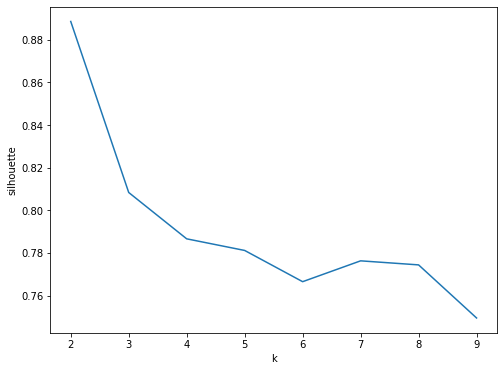

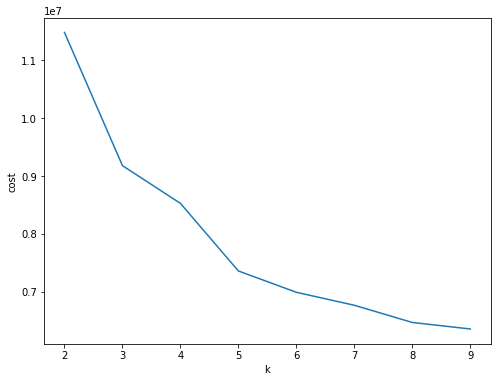

In [9]:
#run k-means

# Loads data
sdf_kmeans=prepare_for_kmeans(sdf)

#show data
sdf_kmeans.show()
print(sdf_kmeans.count())
sdf_kmeans.printSchema()

#find best k
MAX_k=10
costs = np.zeros(MAX_k)
silhouettes = np.zeros(MAX_k)
for k in range(2,MAX_k):
    kmeans = KMeans().setK(k).setSeed(1)
    model = kmeans.fit(sdf_kmeans)
    costs[k] = model.computeCost(sdf_kmeans) # requires Spark 2.0 or later
    predictions = model.transform(sdf_kmeans)
    evaluator = ClusteringEvaluator()
    silhouettes[k] = evaluator.evaluate(predictions)
    
#show best k
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,MAX_k),silhouettes[2:MAX_k])
ax.set_xlabel('k')
ax.set_ylabel('silhouette')

#show best k
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,MAX_k),costs[2:MAX_k])
ax.set_xlabel('k')
ax.set_ylabel('cost')

# Trains a k-means model.
kmeans = KMeans().setK(6).setSeed(1)
model = kmeans.fit(sdf_kmeans)

# Make predictions
predictions = model.transform(sdf_kmeans)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

transformed = model.transform(sdf_kmeans).select('id', 'prediction')
rows = transformed.collect() 
print(rows[:3])
#prediction = spark.createDataFrame(rows)
#prediction.show()

# **MAIN**

# **TEST**

In [12]:
a=prepare_for_kmeans(sdf)
a.describe().show()

+-------+-----+
|summary|   id|
+-------+-----+
|  count|  778|
|   mean| null|
| stddev| null|
|    min|Apt40|
|    max|Apt40|
+-------+-----+



# **Other**

In [ ]:
#create json data from stored dataframe

def to_json(final):
    PERIOD=60

    data_for_json=final.loc[:, final.columns != 'date']

    def date_to_str(o):
        if isinstance(o, datetime.datetime):
            return o.__str__()

    json_dataframe = pd.DataFrame(columns=['data']) #creates a new dataframe that's empty
    L  = []

    import json
    import datetime
    import time

    r, c = data_for_json.shape
    for i in range(0, r):
        for j in range(0, c):
            data = {}
            data['id'] = data_for_json.columns.values[j]
            data['power'] = data_for_json.iloc[i][j]
            data['date']=data_for_json.index.tolist()[i]
            json_data = json.dumps(data,default=date_to_str)
            L.append(json_data)
            #json_dataframe=json_dataframe.append(json_data,ignore_index=True)

    json_dataframe = pd.DataFrame(L, columns=['data'])
    return json_dataframe

In [ ]:
#load by schema

schema = StructType([
  StructField("num", IntegerType()),
    StructField("date", TimestampType()),
    StructField("id", StringType()),
  StructField("power", ArrayType(
      StructType([
          StructField("H0", FloatType(), True),
          StructField("H1", FloatType(), True),
          StructField("H2", FloatType(), True),
          StructField("H3", FloatType(), True),
          StructField("H4", FloatType(), True),
          StructField("H5", FloatType(), True),
          StructField("H6", FloatType(), True),
          StructField("H7", FloatType(), True),
          StructField("H8", FloatType(), True),
          StructField("H9", FloatType(), True),
          StructField("H10", FloatType(), True),
          StructField("H11", FloatType(), True),
          StructField("H12", FloatType(), True),
          StructField("H13", FloatType(), True),
          StructField("H14", FloatType(), True),
          StructField("H15", FloatType(), True),
          StructField("H16", FloatType(), True),
          StructField("H17", FloatType(), True),
          StructField("H18", FloatType(), True),
          StructField("H19", FloatType(), True),
          StructField("H20", FloatType(), True),
          StructField("H21", FloatType(), True),
          StructField("H22", FloatType(), True),
          StructField("H23", FloatType(), True)
      ])
   )
             )])

a = spark.read.format('csv').schema(schema).option("header", "true").load(DATASET_PATH+"f.csv")
a.show()

In [ ]:
#test pandas_udf
from pyspark.sql.functions import pandas_udf, PandasUDFType

my_schema = StructType([
    StructField("id", IntegerType()),
    StructField("age", IntegerType())])
df=spark.read.csv("test.csv", header=True,schema=my_schema)
df.show()
df.printSchema()

def plus_one(a):
    return a+1

plus_one_udf = pandas_udf(plus_one, returnType=IntegerType())

df.select(plus_one_udf(col("age"))).show()